# Tutorial

This Tutorial shows basics of theory and corresponding code to it. We are providing another jupyter notebooks, that can be use for applications without nonsensical text presented here. 

Units of the code are atomic units (Bohr, Hartree, electrons, electrons/Bohr,...)

Equations here are taken from the published paper.

Data used here are computed with Orca at the PBE0/def2-TZVP level. Molecules are randomly selected from QM9 database. Charged molecules later were optimize with charge setup to be +1 or -1 in ORCA without any other changes

In [1]:
import sys
sys.path.append("/home/mvondrak/development/qeqInv/qpac")
from ase.io import read
import numpy as np

from qpac.descriptors import dscribeSOAP,quipSOAP
from qpac.kernel import qpacKernel
from qpac.kQEq import kernel_qeq 
from qpac.utils import *

import matplotlib.pyplot as plt

We start by loading a training and test set:

In [2]:
# Get data
mols_train = read("../data/QMtrainSimple.xyz@:100",format='extxyz')
mols_test = read("../data/TestQM9.xyz@:100",format='extxyz')

In [3]:
species = np.unique([spec  for mol in mols_train for spec in  mol.get_chemical_symbols()])

## Dipole fitting

First we have to create an object of the descriptor. These are able to be loaded from `qpac.descriptors`. At this moment we support 2 SOAP descriptors.

We recommend to use in a production run `quippy` SOAP. Mainly in the case of using a model for larger molecular dynamics simulation of the single system, derivatives here are better implemented.


In [4]:

soap_desctipor = quipSOAP(STRsoap="soap cutoff=3.0 l_max=5 n_max=6 atom_sigma=0.5 normalize=T n_species=5 species_Z={6 9 1 7 8} n_Z=5 Z={6 9 1 7 8}", species=species)


For quick test, or if the forces are not a concerner, the `dscribe` SOAP can be used.

In [5]:
# soap_desctipor_dscribe = dscribeSOAP(nmax = 5,
#                         lmax = 3,
#                         rcut = 2.6,
#                         sigma = 2.6/8,
#                         delta=1.0,
#                         species = species,
#                         periodic = False)


As a next step, we have to set up a kernel. This is done via a `qpacKernel` class from `qpac.kernel` 

In [6]:
qpac_kernel = qpacKernel(Descriptors=soap_desctipor,
                        training_set=mols_train,
                        sparse=True,
                        perEl = True,
                        sparse_method = "CUR",
                        sparse_count=500)

Computing training descriptors for for descriptor number 0
Starting CUR decomposition for each element (final number of sparse points will be number of species * sparse_count)


Finally, we create kQEq model with a kernel

In [7]:
qpac_kqeq = kernel_qeq(Kernel=qpac_kernel,
                    scale_atsize=1/np.sqrt(2.0),
                    radius_type="qeq")

Computed kernel for training
Kernel is done


Now we train the model and predict the dipole moments of the validation and training sets. In this tutorial we are demonstrating only training on a electrostatic target, e.g. dipoles. For creating an interatomic potential, please refer to other jupyter notebooks.

Training is a done with `kernel_qeq.train()` function. This function calculates a regression coefficients with this loss function:
$$
    \mathcal{L}_t = ||\mathbf{t}-\mathbf{t}_{\mathrm{ref}}||^2_{\mathbf{\Sigma}^{-1}_t}+ ||\mathbf{w}||_{\mathbf{K}_{MM}}^2 =||\mathbf{T}_t\mathbf{A}^{-1}(\mathbf{X}\mathbf{K}_{NM}\mathbf{w}-\mathbf{q}_{\mathrm{tot}})-\mathbf{t}_{\mathrm{ref}}||^2_{\mathbf{\Sigma}^{-1}_t}+ ||\mathbf{w}||_{\mathbf{K}_{MM}}^2
$$
Where $t$ is a target (e.g. charges, or dipoles), and T is a corresponding transformation matrix (matrices 28 and 29 in the paper, we are omitting them here for a clearer text).

In [8]:
# Train a model with a given regularization parameter
qpac_kqeq.train(targets=["dipole"], target_sigmas=[1.0])

iterative_targets_current [] []
noniterative_targets_current ['dipole'] [1.0]


####################################################################
New RMSE: 0.1477840581453081
Old RMSE: inf
Bad RMSEs in row: 1
Sample of charges: [-0.21734841 -0.25281126 -0.25281852  0.3600794   0.01990136  0.01989425
  0.13924615  0.14956259  0.14956503  0.13924887]
sum of charges:  -3.885780586188048e-16
iteration 0 is done
####################################################################
Lenght of weights: 1185


If you for some reason interested in calculated weights, you can obtain them with `kernel_qeq.weights`

In [9]:
print(qpac_kqeq.weights.shape) # correspond to each atomic environment in the representative set.
print(qpac_kqeq.weights[:10])

(1185,)
[-0.14936462  0.01131447  0.02554265  0.03082212  0.21155844 -0.06010363
 -0.42482616 -0.01053762  0.03866686 -0.14424895]


We are providing other possible syntax for training. Targets can be combined.

After the training, we can predict values of dipoles

In [10]:
# Predict dipole moments for training and validation set
res_test = qpac_kqeq.predict(mols_test)
res_train = qpac_kqeq.predict(mols_train)

# Get reference values from atoms objects
dipoles_test_ref = get_dipoles(mols_test)
dipoles_train_ref = get_dipoles(mols_train)

Bulk prediction of qs, and dipoles started
Bulk prediction of qs, and dipoles started


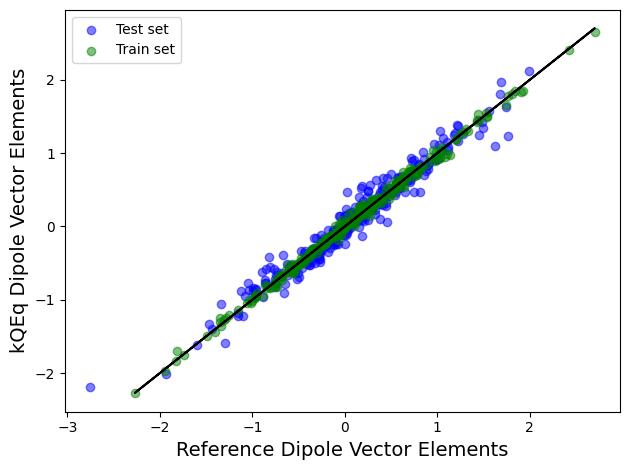

In [11]:
# Plot the results
plt.scatter(dipoles_test_ref,res_test["dipoles"], c='blue', alpha=0.5, label='Test set')  
plt.scatter(dipoles_train_ref,res_train["dipoles"], c='green', alpha=0.5, label='Train set')
plt.plot(dipoles_train_ref,dipoles_train_ref, color="black") 
plt.legend()
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.tight_layout()

Note that there are two ways to run a kQEq model on a new system, namely `.predict` and `.calculate` (we have also a function `.calculateEQ`, that does not compute forces). The former is for batch applications (e.g. on the full validation set), the latter for predictions on single system (as in the corresponding ase calculator). 

`kernel_qeq.predict` returns dipoles and charges as a dictionary. If used on periodic systems, the dipole have no true meaning here.
`kernel_qeq.calculate` returns charges, energies and forces as a dictionary. Because forces can be expensive to calculate, we provide `kernel_qeq.calculateEQ` function, that returns only charges and anenergies



In [12]:
# Calculate vs. Predict:
result_bulk = qpac_kqeq.predict([mols_test[4]])
result_single = qpac_kqeq.calculate(mols_test[4])
print(result_bulk["charges"])
print(result_single['charges'])

Bulk prediction of qs, and dipoles started
f (15, 3)
[-0.66551377  0.30598027 -0.09185161 -0.02235773 -0.35195904 -0.01070243
 -0.09185295  0.40496564  0.00601678  0.06381783  0.06854049  0.13057552
  0.13057551  0.05994763  0.06381786]
[-0.66551377  0.30598027 -0.09185161 -0.02235773 -0.35195904 -0.01070243
 -0.09185295  0.40496564  0.00601678  0.06381783  0.06854049  0.13057552
  0.13057551  0.05994763  0.06381786]


## Dipole + charges fitting

This is very brief section. We will reused `soap_descriptor`, `qpac_kernel`, and `qpac_kqeq` set up before. We just have to retrain the model. This retraining can be done, since there is nothing except weights changed by training. Different $\sigma_t$ has to be set up for both targets. Charges are taken from `ase.Atoms` object, so charge_keyword has to be a word, which will get correct array through the `mol.arrays[charge_keyword]`. If the charges are not in Atoms object, they can be passed through the `custom_target` as a numpy array.    

In [13]:
qpac_kqeq.train(targets=["dipole","charges"],target_sigmas=[1.0,0.5],charge_keyword="mulliken")

iterative_targets_current [] []
noniterative_targets_current ['dipole', 'charges'] [1.0, 0.5]
####################################################################
New RMSE: 0.08891833685445114
Old RMSE: inf
Bad RMSEs in row: 1
Sample of charges: [ 0.16550455 -0.30882901 -0.30883039  0.23706653  0.13338568  0.13338219
  0.13798244  0.14788148  0.14788213  0.13798328]
sum of charges:  6.661338147750939e-16
iteration 0 is done
####################################################################
Lenght of weights: 1185


In [14]:
# Predict dipole moments for training and validation set
res_test = qpac_kqeq.predict(mols_test)
res_train = qpac_kqeq.predict(mols_train)

# Get reference values from atoms objects
dipoles_test_ref = get_dipoles(mols_test)
dipoles_train_ref = get_dipoles(mols_train)

charges_test_ref = get_charges(mols_test,charge_keyword="mulliken")
charges_train_ref = get_charges(mols_train,charge_keyword="mulliken")

Bulk prediction of qs, and dipoles started
Bulk prediction of qs, and dipoles started


In [15]:
from qpac.utils import RMSE
rmse_train_dipole_mixed_target = RMSE(dipoles_train_ref,res_train["dipoles"])
rmse_test_dipole_mixed_target = RMSE(dipoles_test_ref,res_test["dipoles"])
rmse_train_charges_mixed_target = RMSE(charges_train_ref,res_train["charges"])
rmse_test_charges_mixed_target = RMSE(charges_test_ref,res_test["charges"])

print(f"RMSE of dipoles of train set {rmse_train_dipole_mixed_target:.4f} in comparison with RMSE only fitting dipole TBD")
print(f"RMSE of dipoles of test set {rmse_test_dipole_mixed_target:.4f} in comparison with RMSE only fitting dipole TBD")
print(f"RMSE of charges of train set {rmse_train_charges_mixed_target:.4f}")
print(f"RMSE of charges of test set {rmse_test_charges_mixed_target:.4f}")

RMSE of dipoles of train set 0.0715 in comparison with RMSE only fitting dipole TBD
RMSE of dipoles of test set 0.1499 in comparison with RMSE only fitting dipole TBD
RMSE of charges of train set 0.0241
RMSE of charges of test set 0.0392


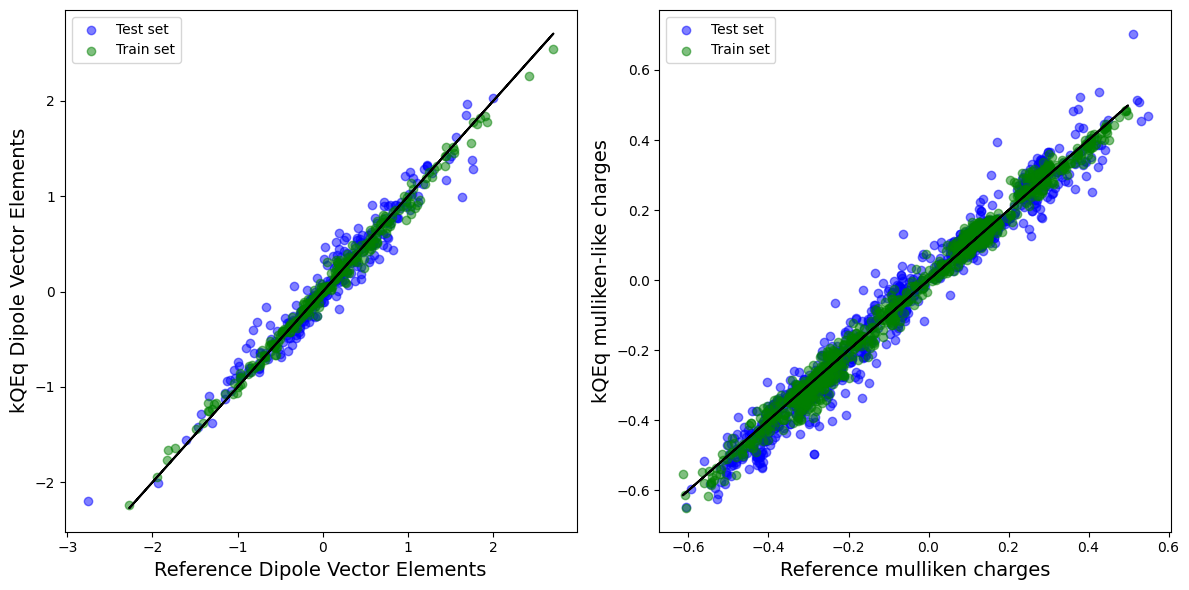

In [16]:

# Plot the results

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(dipoles_test_ref,res_test["dipoles"], c='blue', alpha=0.5, label='Test set')  
axs[0].scatter(dipoles_train_ref,res_train["dipoles"], c='green', alpha=0.5, label='Train set')
axs[0].plot(dipoles_train_ref,dipoles_train_ref, color="black") 
axs[0].legend()
axs[0].set_xlabel('Reference Dipole Vector Elements',fontsize=14)
axs[0].set_ylabel('kQEq Dipole Vector Elements',fontsize=14)

axs[1].scatter(charges_test_ref,res_test["charges"], c='blue', alpha=0.5, label='Test set')  
axs[1].scatter(charges_train_ref,res_train["charges"], c='green', alpha=0.5, label='Train set')
axs[1].plot(charges_train_ref,charges_train_ref, color="black") 
axs[1].legend()
axs[1].set_xlabel('Reference mulliken charges',fontsize=14)
axs[1].set_ylabel('kQEq mulliken-like charges',fontsize=14)
plt.tight_layout()

## Charged molecules fitting and multiple descriptors

As last part, we will show how to fit charged systems. For this endeavor, we are loading water clusters containing 6 water molecules. Positive and negative clasters have added or removed hydrogen.

In [17]:
mols_positive = read("../data/posW6.xyz@:100",format='extxyz')
mols_negative = read("../data/negW6.xyz@:100",format='extxyz')
mols_neutral = read("../data/neutW6.xyz@:100",format="extxyz") # we are loading it again for clarity of this part
random.seed(10)
random.shuffle(mols_positive)
random.shuffle(mols_negative)
random.shuffle(mols_neutral)
print(f"{len(mols_neutral)} neutral systems")
print(f"{len(mols_positive)} positively charged systems")
print(f"{len(mols_negative)} negatively charged systems")

100 neutral systems
100 positively charged systems
100 negatively charged systems


From each set, we take 80 to the training set and 20 to the test set.

In [18]:

positive_train = mols_positive[:80]
positive_test = mols_positive[80:]
negative_train = mols_negative[:80]
negative_test = mols_negative[80:]
neutral_train = mols_neutral[:80]
neutral_test = mols_neutral[80:]
combined_training = positive_train + negative_train + neutral_train


We have to set a charges of the systems for training, and folowing predictions.

In [19]:
charges_positive_train = [1 for _ in positive_train]
charges_positive_test = [1 for _ in positive_test]
charges_negative_train = [-1 for _ in negative_train]
charges_negative_test = [-1 for _ in negative_test]
charges_neutral_train = [0 for _ in neutral_train]
charges_neutral_test = [0 for _ in neutral_test]
combined_charges_training = charges_positive_train + charges_negative_train +charges_neutral_train

Fitting 3 different charge states is more difficult than fitting only neutral molecules. For this reason, we use 2 different descriptors. 

In [20]:
soap_descriptor = quipSOAP(STRsoap="soap cutoff=2.4 l_max=5 n_max=6 atom_sigma=0.5 normalize=T n_species=2 species_Z={1 8} n_Z=2 Z={1 8}", species=["O","H"])
soap_descriptor2 = quipSOAP(STRsoap="soap cutoff=4.2 l_max=3 n_max=10 atom_sigma=1.0 normalize=T n_species=2 species_Z={1 8} n_Z=2 Z={1 8}", species=["O","H"])

Both desritpors has to be passed as a list to the `qpacKernel` class. CUR decomposition will be done twice, for each descriptor separatly.  

In [22]:
qpac_kernel = qpacKernel(Descriptors=[soap_descriptor,soap_descriptor2],
                        training_set=combined_training,
                        training_set_charges=combined_charges_training,
                        sparse=True,
                        perEl = True,
                        sparse_method = "CUR",
                        sparse_count=500)

Computing training descriptors for for descriptor number 0
Computing training descriptors for for descriptor number 1
Starting CUR decomposition for each element (final number of sparse points will be number of species * sparse_count)


1 hyperparameter we have to choose is a `scale_atsize`. In the previous examples, we left scaling $\frac{1}{\sqrt{2}}$. Herein, we use smaller radii, we encourage small experimentation with different sizes to see what is happening with th efinal fit

In [23]:
qpac_kqeq = kernel_qeq(Kernel=qpac_kernel,
                    scale_atsize=0.75/np.sqrt(2.0),
                    radius_type="qeq")

Computed kernel for training
Kernel is done


Training itself is the same as before

In [31]:
qpac_kqeq.train(targets=["charges"], target_sigmas=[0.01],charge_keyword="hirshfeld")

iterative_targets_current [] []
noniterative_targets_current ['charges'] [0.01]
####################################################################
New RMSE: 0.1247117811896411
Old RMSE: inf
Bad RMSEs in row: 1
Sample of charges: [ 0.13273552 -0.28404882  0.14918896  0.11938605 -0.28634858  0.11416083
  0.11559611 -0.25795645  0.11167406  0.1390382 ]
sum of charges:  7.105427357601002e-15
iteration 0 is done
####################################################################
Lenght of weights: 2000


For prediction we have to supply lists of total charges of the systems with `predict_system_charges`.

In [32]:
res_positive_train = qpac_kqeq.predict(positive_train,predict_system_charges=charges_positive_train)
res_positive_test = qpac_kqeq.predict(positive_test,predict_system_charges=charges_positive_test)
res_negative_train = qpac_kqeq.predict(negative_train,predict_system_charges=charges_negative_train)
res_negative_test = qpac_kqeq.predict(negative_test,predict_system_charges=charges_negative_test)
res_neutral_train = qpac_kqeq.predict(neutral_train,predict_system_charges=charges_neutral_train)
res_neutral_test = qpac_kqeq.predict(neutral_test,predict_system_charges=charges_neutral_test)

Bulk prediction of qs, and dipoles started


Bulk prediction of qs, and dipoles started
Bulk prediction of qs, and dipoles started
Bulk prediction of qs, and dipoles started
Bulk prediction of qs, and dipoles started
Bulk prediction of qs, and dipoles started


We can check that charges per systems are correct.

In [33]:
print("Charge of 1 system in the positive training set:", np.sum(res_positive_train["charges"])/len(positive_train))
print("Charge of 1 system in the positive training set:", np.sum(res_positive_test["charges"])/len(positive_test))
print("Charge of 1 system in the positive training set:", np.sum(res_negative_train["charges"])/len(negative_train))
print("Charge of 1 system in the positive training set:", np.sum(res_negative_test["charges"])/len(negative_test))
print("Charge of 1 system in the positive training set:", np.sum(res_neutral_train["charges"])/len(neutral_train))
print("Charge of 1 system in the positive training set:", np.sum(res_neutral_test["charges"])/len(neutral_test))

Charge of 1 system in the positive training set: 1.0
Charge of 1 system in the positive training set: 1.0
Charge of 1 system in the positive training set: -1.0
Charge of 1 system in the positive training set: -1.0
Charge of 1 system in the positive training set: -2.393918396847994e-17
Charge of 1 system in the positive training set: 8.326672684688674e-18


We load charges from datasets. Here we are not looking on Mulliken charges, but Hirshfled ones.

In [34]:
ref_positive_train = get_charges(positive_train,"hirshfeld")
ref_positive_test = get_charges(positive_test,"hirshfeld")
ref_negative_train = get_charges(negative_train,"hirshfeld")
ref_negative_test = get_charges(negative_test,"hirshfeld")
ref_neutral_train = get_charges(neutral_train,"hirshfeld")
ref_neutral_test = get_charges(neutral_test,"hirshfeld")
ref_all_train = np.concatenate([ref_neutral_train, ref_positive_train, ref_negative_train]) 
ref_all_test = np.concatenate([ref_neutral_test, ref_positive_test, ref_negative_test])

In [35]:
print("RMSE of positive train set:",RMSE(ref_positive_train,res_positive_train["charges"]))
print("RMSE of negative train set:",RMSE(ref_negative_train,res_negative_train["charges"]))
print("RMSE of neutral train set:",RMSE(ref_neutral_train,res_neutral_train["charges"]))
print("RMSE of positive test set:",RMSE(ref_positive_test,res_positive_test["charges"]))
print("RMSE of negative test set:",RMSE(ref_negative_test,res_negative_test["charges"]))
print("RMSE of neutral test set:",RMSE(ref_neutral_test,res_neutral_test["charges"]))

RMSE of positive train set: 0.008408319128848823
RMSE of negative train set: 0.010143190453259742
RMSE of neutral train set: 0.009180415782460802
RMSE of positive test set: 0.009178731068674645
RMSE of negative test set: 0.011230828557348704
RMSE of neutral test set: 0.009345967356309033


### And final plots for charge systems. **Please se other tutorials and/or `examples` folder for how to train interatomic potentials with kQEq.**

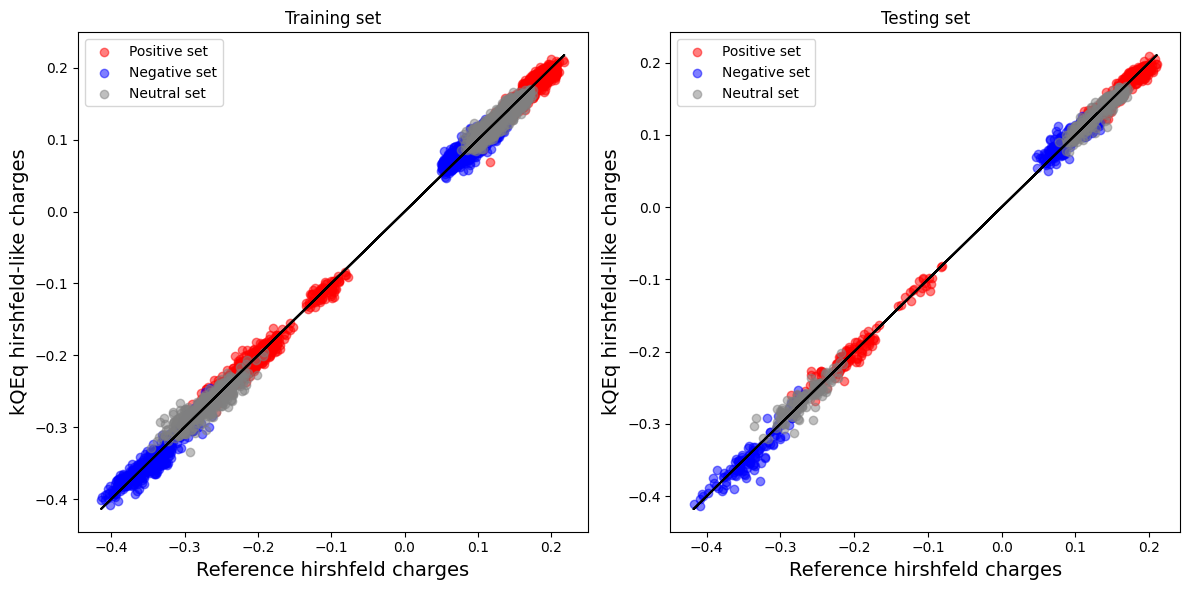

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("Training set")
axs[0].scatter(ref_positive_train,res_positive_train["charges"], c='red', alpha=0.5, label='Positive set')
axs[0].scatter(ref_negative_train,res_negative_train["charges"], c='blue', alpha=0.5, label='Negative set')
axs[0].scatter(ref_neutral_train,res_neutral_train["charges"], c='grey', alpha=0.5, label='Neutral set')  
axs[0].plot(ref_all_train,ref_all_train, color="black") 
axs[0].legend()
axs[0].set_xlabel('Reference hirshfeld charges',fontsize=14)
axs[0].set_ylabel('kQEq hirshfeld-like charges',fontsize=14)

axs[1].set_title("Testing set")
axs[1].scatter(ref_positive_test,res_positive_test["charges"], c='red', alpha=0.5, label='Positive set')
axs[1].scatter(ref_negative_test,res_negative_test["charges"], c='blue', alpha=0.5, label='Negative set')
axs[1].scatter(ref_neutral_test,res_neutral_test["charges"], c='grey', alpha=0.5, label='Neutral set')
axs[1].plot(ref_all_test,ref_all_test, color="black")   
axs[1].legend()
axs[1].set_xlabel('Reference hirshfeld charges',fontsize=14)
axs[1].set_ylabel('kQEq hirshfeld-like charges',fontsize=14)
plt.tight_layout()